# Question 1: Classifier

In [1]:
import os
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from transformers import AdamW, AutoTokenizer, BertModel
from utils.data_loader_classifier import MultipleChoiceDataloader, read_file, read_json_data
from utils.test_classifier import test_loop
from utils.train_classifier import train_loop
from utils.valid_classifier import valid_loop
from utils.zero_shot_classifier import evaluate

In [2]:
NUM_EPOCHS = 5
PRINT_EVERY = 100
BATCH_SIZE = 150
TEST_MODE = True

## Dataloader

In [3]:
train_file_name = "data/train_complete.jsonl"
dev_file_name = "data/dev_complete.jsonl"
test_file_name = "data/test_complete.jsonl"

In [4]:
train_json = read_file(train_file_name)
dev_json = read_file(dev_file_name)
test_json = read_file(test_file_name)

In [5]:
train_dataset = read_json_data(train_json)
dev_dataset = read_json_data(dev_json, permute=False)
test_dataset = read_json_data(test_json, permute=False)

In [6]:
train_dataloader = MultipleChoiceDataloader(train_dataset, batch_size=BATCH_SIZE)
dev_dataloader = MultipleChoiceDataloader(dev_dataset, batch_size=BATCH_SIZE)
test_dataloader = MultipleChoiceDataloader(test_dataset, batch_size=BATCH_SIZE)

Sample sequence:

In [7]:
for text, label in train_dataloader:
    print(text[0])
    print(label[0])
    break

[CLS] the sun is the source of energy for physical cycles on Earth [SEP] The sun is responsible for puppies learning new tricks [SEP] children growing up and getting old [SEP] flowers wilting in a vase [SEP] plants sprouting, blooming and wilting [END]
tensor([0, 0, 0, 1])


The answers and stem are encoded as a single sequence. Everything is separated using `[SEP]`; so our format is `[CLS] stem [SEP] option [SEP] option [SEP] option [SEP] option [END]`. For example:

```
[CLS] the sun is the source of energy for physical cycles on Earth [SEP] The sun is responsible for puppies learning new tricks [SEP] children growing up and getting old [SEP] flowers wilting in a vase [SEP] plants sprouting, blooming and wilting [END]
```

* Utilize `MultipleChoiceDataloader` to load training, validation, and test datasets with a specified batch size.
* Perform data augmentation by permuting the options to artificially increase the dataset size and prevent the model from memorizing the choices.
* For each instance, encode the text as described and retrieve the context embedding for the `[CLS]` token from the top of the transformer stack.

## Hyperparameter Tuning

* Using `AutoTokenizer` from the Hugging Face Transformers library to ensure that the tokenization process is consistent with the pre-trained BERT model. `bert-base-uncased` is a commonly used BERT model that is trained on lowercase English text.
* `BertModel` class provides the bare BERT model without any additional heads.

In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
linear = nn.Linear(768, 4)

* `AdamW` is preferred over Adam for fine-tuning transformer models like BERT because it decouples weight decay from the gradient update, providing a more effective regularization method. This helps prevent overfitting by ensuring that the weights do not grow too large.
* Different learning rates are tested to find the optimal value that balances convergence speed and stability.
* Different values are tested to determine the best regularization strength.
* Varying dropout probabilities helps in mitigating overfitting by randomly dropping units during training, forcing the model to generalize better.

In [9]:
hyperparams = {
    "learning_rate": [1e-5, 3e-5, 5e-5],
    "weight_decay": [0.01, 0.05],
    "dropout_prob": [0.1, 0.3],
}
param_combinations = list(product(*hyperparams.values()))
param_names = list(hyperparams.keys())

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Do not run the code snippet below unless you want to train all the hyperparameters.

In [12]:
if not TEST_MODE:
    results = []

    for values in param_combinations:
        params = dict(zip(param_names, values))
        print("Training with parameters:", params)

        model.config.hidden_dropout_prob = params["dropout_prob"]
        model.config.attention_probs_dropout_prob = params["dropout_prob"]
        optimizer = AdamW(
            [{"params": model.parameters()}, {"params": linear.parameters()}],
            lr=params["learning_rate"],
            weight_decay=params["weight_decay"],
        )
        model.to(device)
        linear.to(device)

        epoch_train_losses = []
        epoch_train_accuracies = []
        epoch_valid_losses = []
        epoch_valid_accuracies = []

        for epoch in range(NUM_EPOCHS):
            print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
            print("Training...")
            train_dataloader.shuffle_data()
            train_metrics = train_loop(
                train_dataloader,
                tokenizer,
                model,
                linear,
                loss_fn,
                optimizer,
                device,
                PRINT_EVERY,
            )
            epoch_train_losses.append(train_metrics[0])
            epoch_train_accuracies.append(train_metrics[1])

            print("Validating...")
            valid_metrics = valid_loop(
                dev_dataloader,
                tokenizer,
                model,
                linear,
                loss_fn,
                device,
                PRINT_EVERY,
            )
            epoch_valid_losses.append(valid_metrics[0])
            epoch_valid_accuracies.append(valid_metrics[1])

            results.append(
                {
                    **params,
                    "epoch": epoch + 1,
                    "train_loss": train_metrics[0],
                    "train_accuracy": train_metrics[1],
                    "valid_loss": valid_metrics[0],
                    "valid_accuracy": valid_metrics[1],
                }
            )

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(epoch_train_losses, label="Train Loss")
        plt.plot(epoch_valid_losses, label="Valid Loss")
        plt.title("Training and Validation Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epoch_train_accuracies, label="Train Accuracy")
        plt.plot(epoch_valid_accuracies, label="Valid Accuracy")
        plt.title("Training and Validation Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()

        param_info = "\n".join([f"{key}: {val}" for key, val in params.items()])
        plt.figtext(
            0.5,
            0.01,
            param_info,
            ha="center",
            fontsize=10,
            bbox={"facecolor": "white", "alpha": 0.5, "pad": 5},
        )

        plot_path = os.path.join(
            os.getcwd(),
            "imgs",
            f'epoch_metrics_{params["learning_rate"]}_{params["weight_decay"]}_{params["dropout_prob"]}.png',
        )
        plt.savefig(plot_path, bbox_inches="tight")
        plt.close()
        print(f"Saved plot to {plot_path}")

In [13]:
if not TEST_MODE:
    results_df = pd.DataFrame(results)
    csv_path = os.path.join(
        os.getcwd(),
        "results",
        "classifer_hyperparam_results.csv",
    )
    results_df.to_csv(csv_path, index=False)
    print(f"Saved hyperparameter tuning results to '{csv_path}'.")

## Analyzing Results

In [14]:
csv_path = os.path.join(
    os.getcwd(),
    "results",
    "classifer_hyperparam_results.csv",
)
results_df = pd.read_csv(csv_path)

Display the top 10 configurations with the highest validation accuracy.


In [15]:
results_df.sort_values(by=["valid_accuracy"], ascending=False).head(10)

,learning_rate,weight_decay,dropout_prob,epoch,train_loss,train_accuracy,valid_loss,valid_accuracy
16,0.00001,0.05,0.3,2,0.001895,0.999412,3.025279,0.650
8,0.00001,0.01,0.3,4,0.004772,0.998672,2.570021,0.648
9,0.00001,0.01,0.3,5,0.003771,0.998832,2.722092,0.642
10,0.00001,0.05,0.1,1,0.003055,0.999075,2.997681,0.640
17,0.00001,0.05,0.3,3,0.002148,0.999395,2.922371,0.638
30,0.00003,0.05,0.1,1,0.001867,0.999479,3.057198,0.636
2,0.00001,0.01,0.1,3,0.051929,0.981449,2.159948,0.636
15,0.00001,0.05,0.3,1,0.002088,0.999386,2.923141,0.636
28,0.00003,0.01,0.3,4,0.003186,0.999101,2.789884,0.636
14,0.00001,0.05,0.1,5,0.002023,0.999462,2.926276,0.634


Let's select the top hyperparameters from here and view their training curves.

In [16]:
image_path = "imgs/"

In [17]:
metrics = [
    (1e-05, 0.05, 0.3),
    (1e-05, 0.01, 0.3),
    (1e-05, 0.01, 0.3),
    (1e-05, 0.05, 0.1),
    (1e-05, 0.05, 0.3),
]

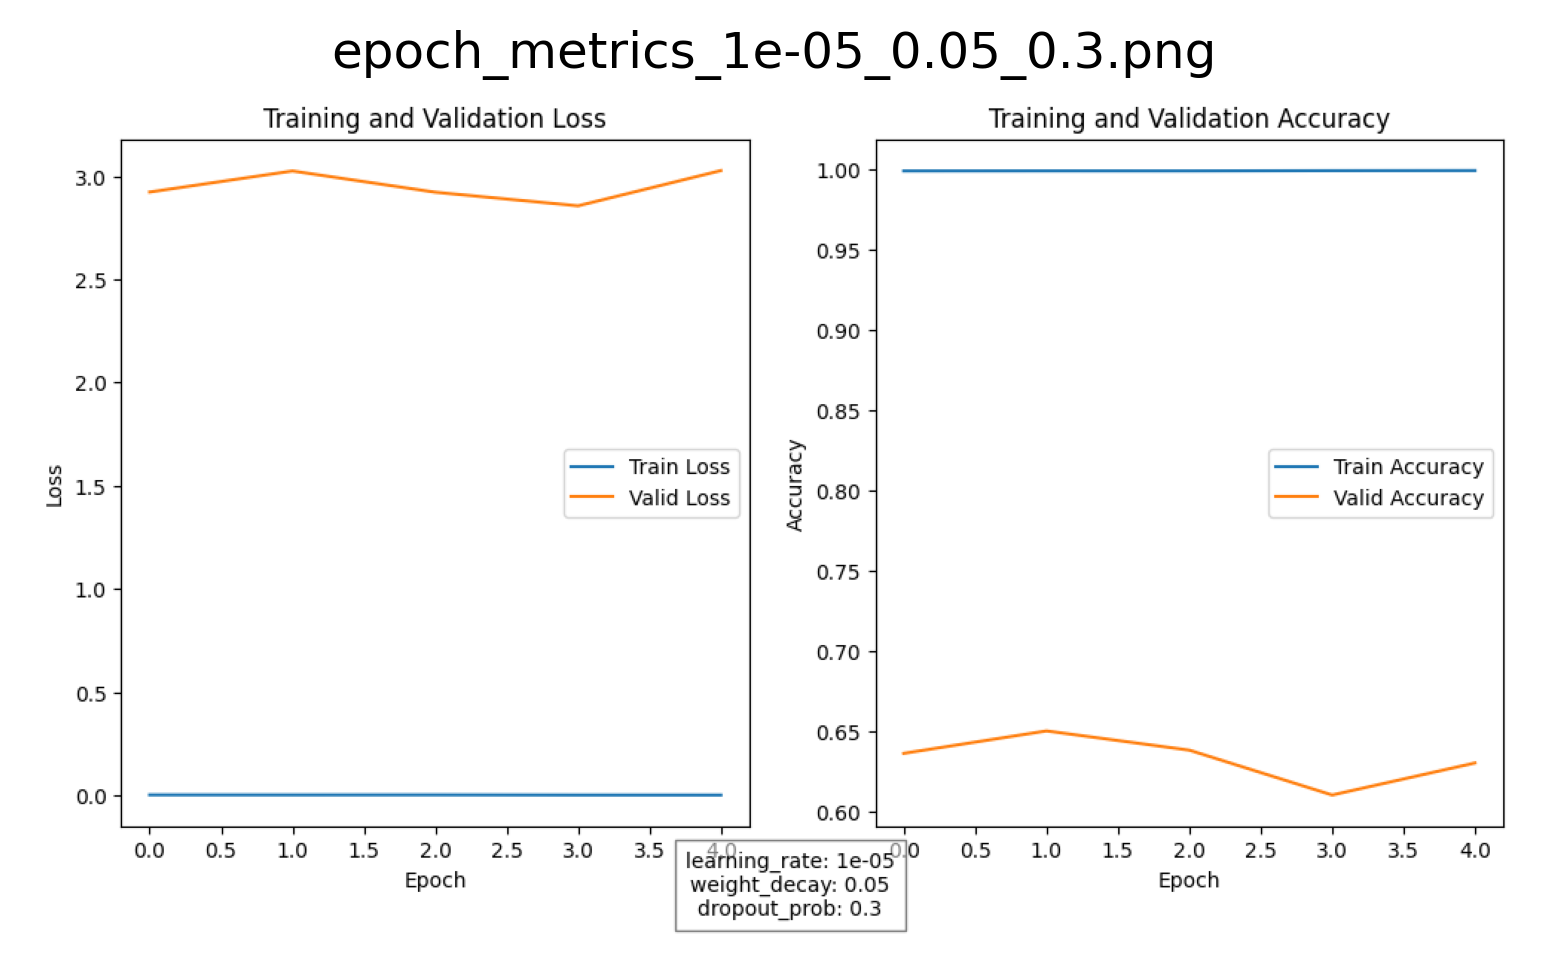

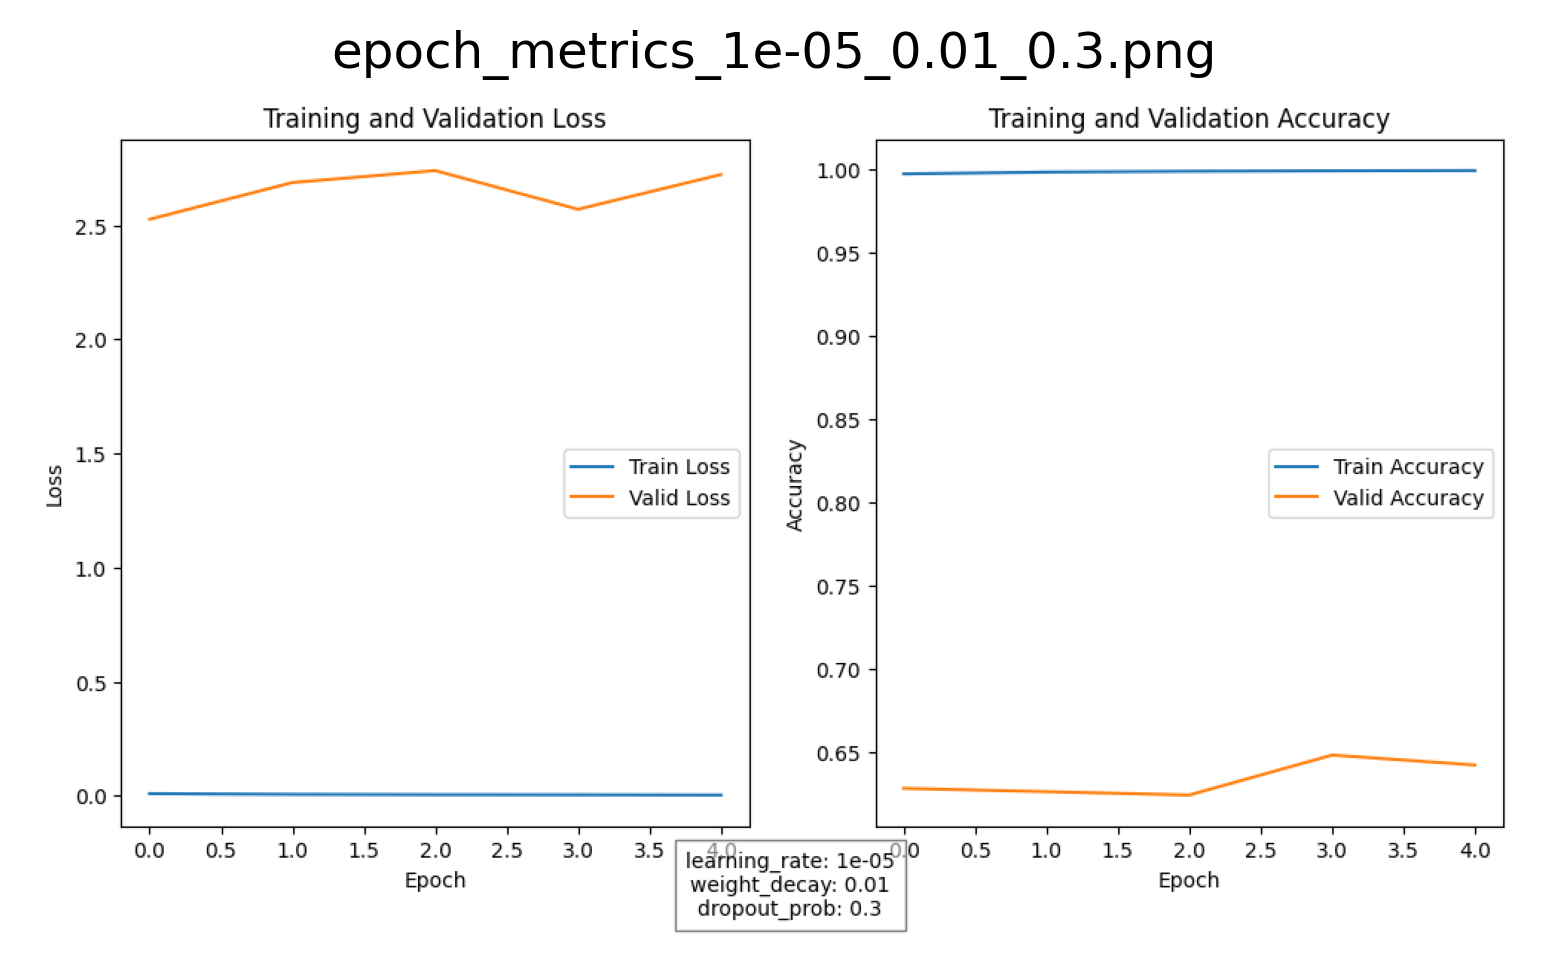

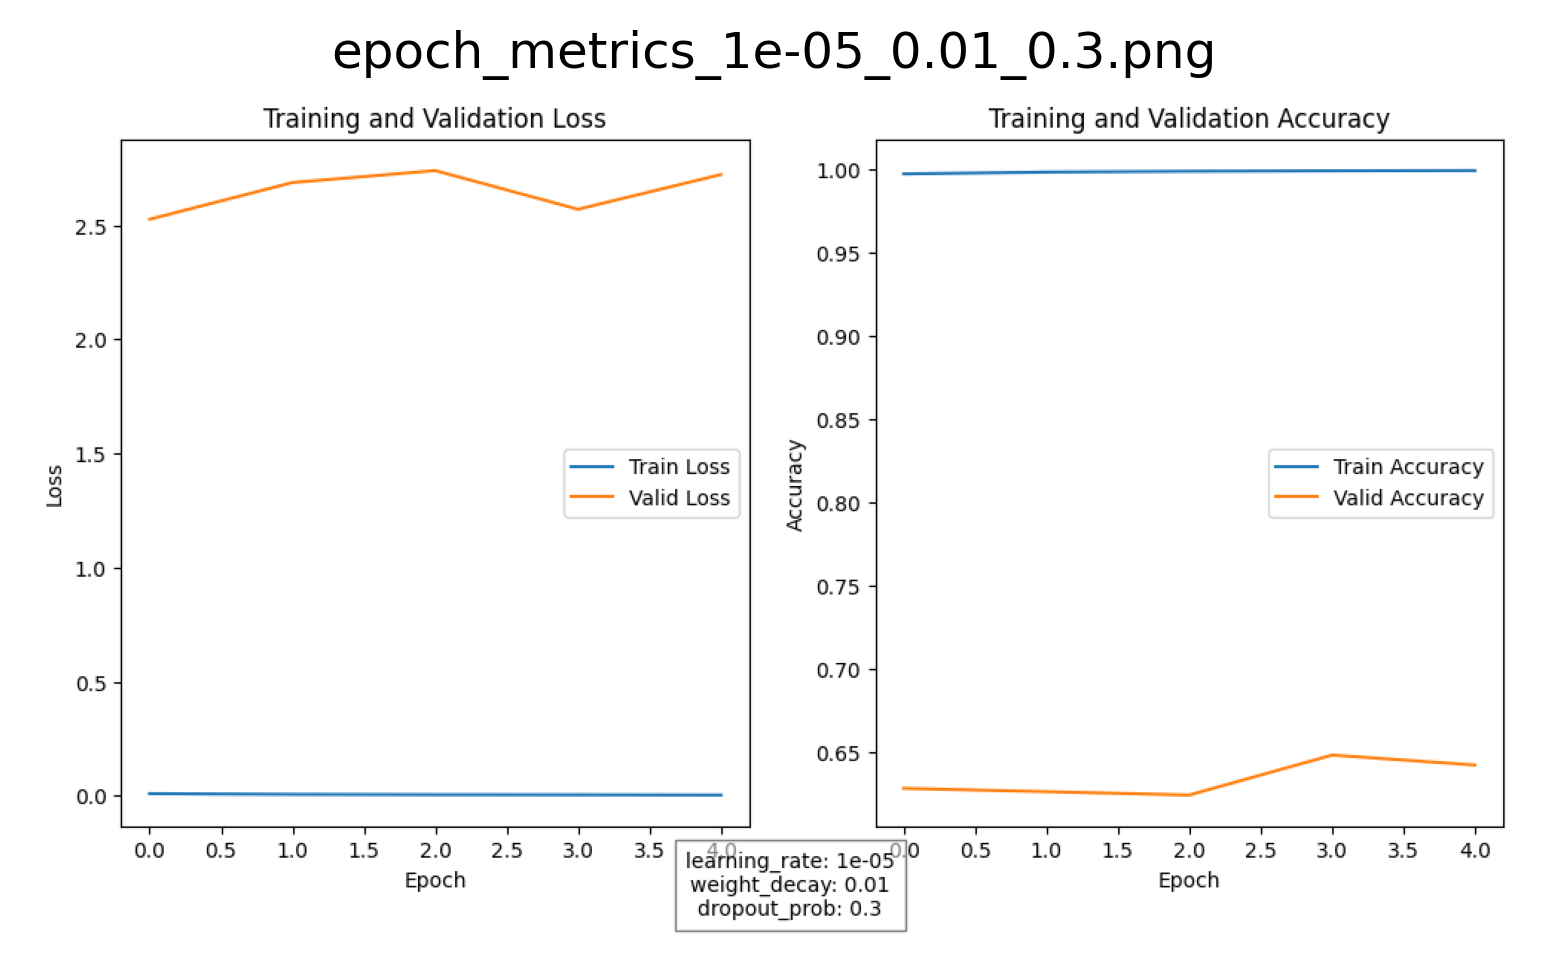

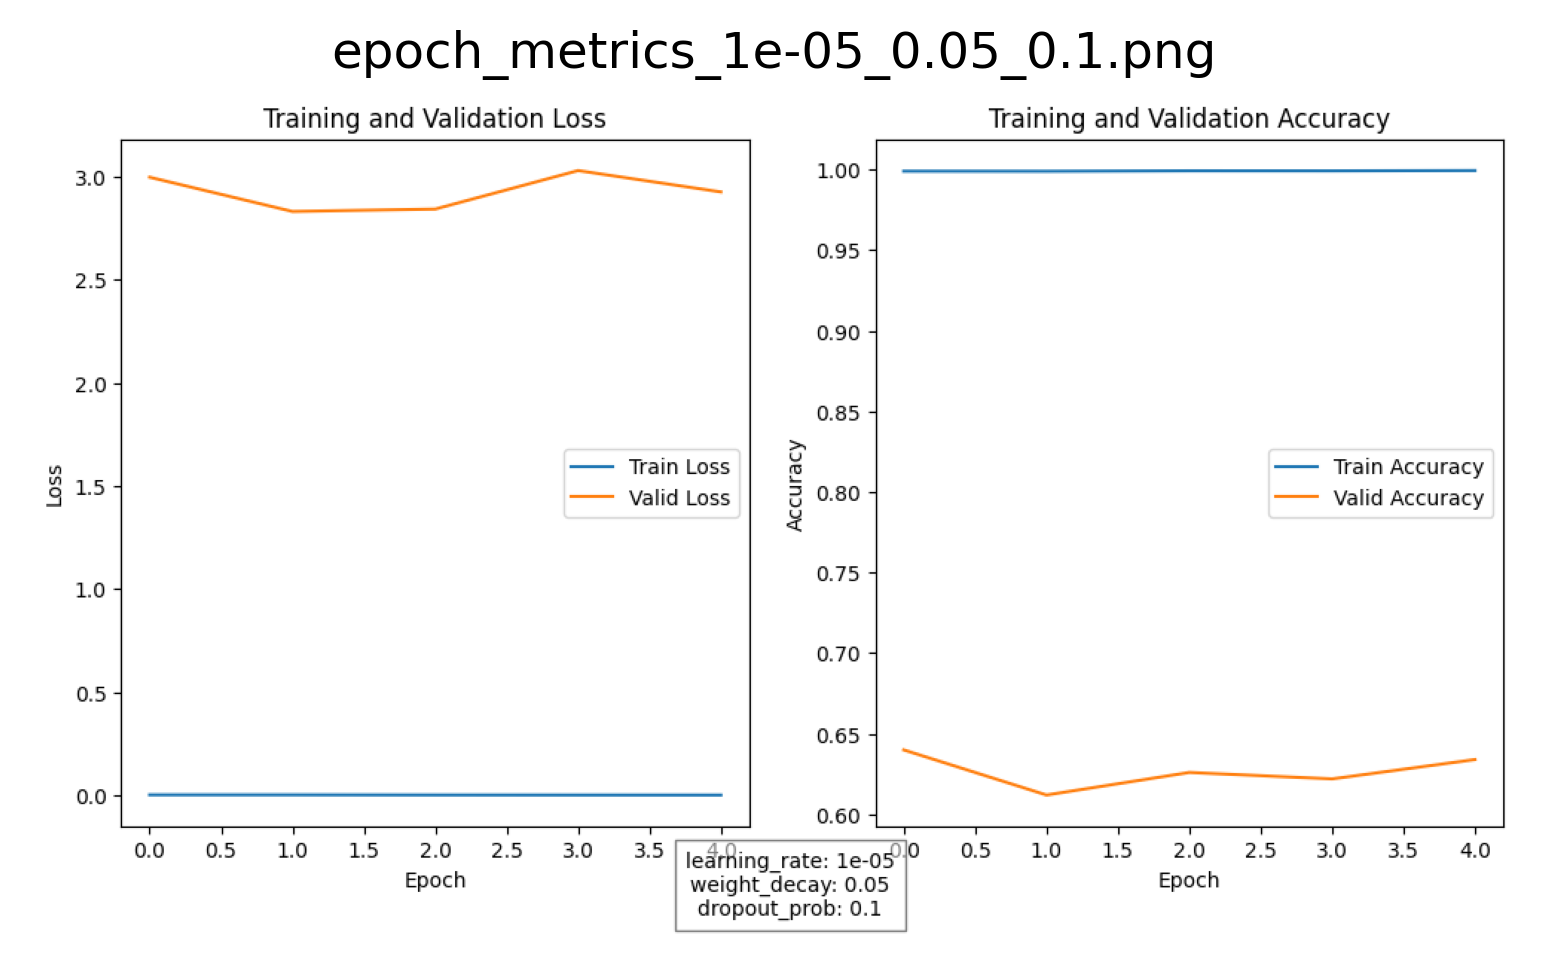

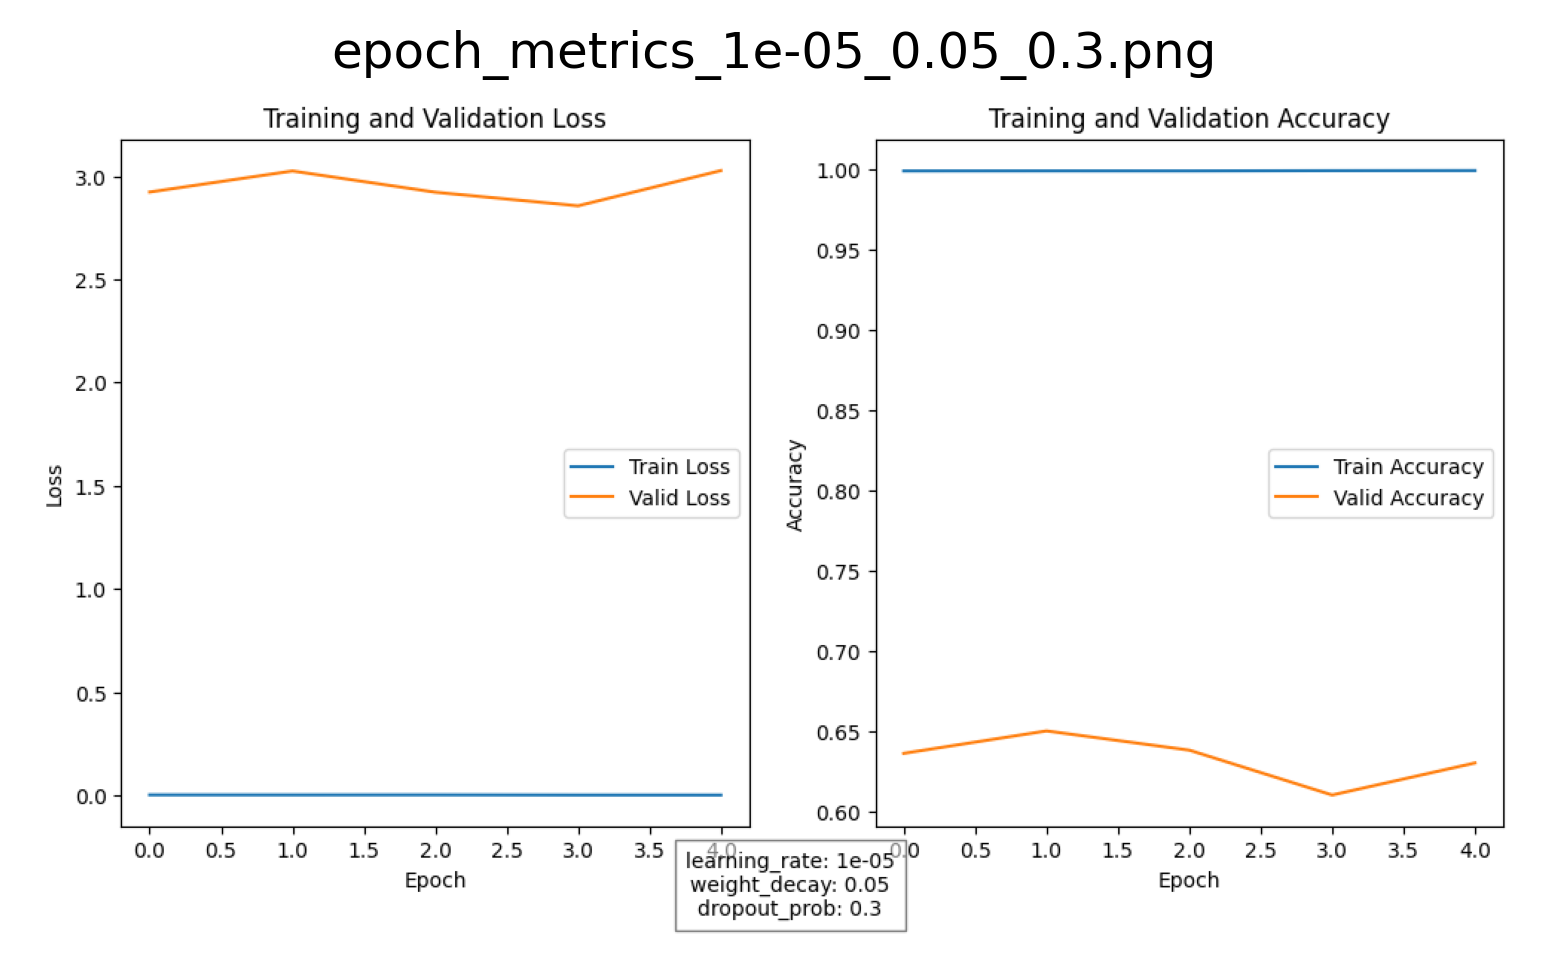

In [18]:
for metric in metrics:
    lr, wd, dp = metric
    image_filename = f"epoch_metrics_{lr}_{wd}_{dp}.png"
    img_path = os.path.join(os.getcwd(), image_path, image_filename)

    if os.path.exists(img_path):
        img = Image.open(img_path)
        plt.figure(dpi=300)
        plt.imshow(img)
        plt.axis("off")
        plt.title(image_filename)
        plt.show()
    else:
        print(f"Image {image_filename} not found in {image_path}")

## Training best model

We can see that the model performs the best after just two epochs with the following hyperparams on the validation accuracy, so let's use those hyperparameters.

In [19]:
LEARNING_RATE = 0.00001
WEIGHT_DECAY = 0.05
DROPOUT_PROB = 0.3
EPOCH = 2

In [20]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
linear = nn.Linear(768, 4)

In [21]:
model.config.hidden_dropout_prob = DROPOUT_PROB
model.config.attention_probs_dropout_prob = DROPOUT_PROB
optimizer = AdamW(
    [{"params": model.parameters()}, {"params": linear.parameters()}],
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
model.to(device)
linear.to(device)

/home/ubuntu/venv/lib/python3.10/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Linear(in_features=768, out_features=4, bias=True)

In [22]:
epoch_train_losses = []
epoch_train_accuracies = []
epoch_valid_losses = []
epoch_valid_accuracies = []

In [23]:
if not TEST_MODE:
    for epoch in range(EPOCH):
        print(f"Epoch {epoch + 1}/{EPOCH}")
        print("Training...")
        train_dataloader.shuffle_data()
        train_metrics = train_loop(
            train_dataloader,
            tokenizer,
            model,
            linear,
            loss_fn,
            optimizer,
            device,
            PRINT_EVERY,
        )
        epoch_train_losses.append(train_metrics[0])
        epoch_train_accuracies.append(train_metrics[1])

        print("Validating...")
        valid_metrics = valid_loop(
            dev_dataloader,
            tokenizer,
            model,
            linear,
            loss_fn,
            device,
            PRINT_EVERY,
        )
        epoch_valid_losses.append(valid_metrics[0])
        epoch_valid_accuracies.append(valid_metrics[1])

In [24]:
if not TEST_MODE:
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_train_losses, label="Train Loss")
    plt.plot(epoch_valid_losses, label="Valid Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epoch_train_accuracies, label="Train Accuracy")
    plt.plot(epoch_valid_accuracies, label="Valid Accuracy")
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    param_info = f"Learning Rate: {LEARNING_RATE}, Weight Decay: {WEIGHT_DECAY}, Dropout: {DROPOUT_PROB}"
    plt.figtext(
        0.5,
        0.01,
        param_info,
        ha="center",
        fontsize=10,
        bbox={"facecolor": "white", "alpha": 0.5, "pad": 5},
    )

    plt.show()

In [25]:
model_weights_path = f"model_weights/model_epoch_{EPOCH}_lr_{LEARNING_RATE}_wt_decay_{WEIGHT_DECAY}_drp_{DROPOUT_PROB}.pth"
linear_weights_path = f"model_weights/linear_epoch_{EPOCH}_lr_{LEARNING_RATE}_wt_decay_{WEIGHT_DECAY}_drp_{DROPOUT_PROB}.pth"

In [26]:
if not TEST_MODE:
    torch.save(
        model.state_dict(),
        model_weights_path,
    )
    torch.save(
        linear.state_dict(),
        linear_weights_path,
    )

## Testing best model

In [27]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
linear = nn.Linear(768, 4)

In [28]:
model.load_state_dict(torch.load(model_weights_path))
linear.load_state_dict(torch.load(linear_weights_path))

<All keys matched successfully>

In [29]:
model.to(device)
linear.to(device)

Linear(in_features=768, out_features=4, bias=True)

In [30]:
print("Testing with specified hyperparameters...")
test_metrics = test_loop(
    test_dataloader, tokenizer, model, linear, loss_fn, device, PRINT_EVERY
)
print(f"Test Loss: {test_metrics[0]}, Test Accuracy: {test_metrics[1]}")

Testing with specified hyperparameters...
Testing finished: Loss = 1.7936, Accuracy = 0.6380, Total time = 1.06s
Test Loss: 1.7936483025550842, Test Accuracy: 0.638


## Zero-Shot Learning

In [31]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")
linear = nn.Linear(768, 4)

In [32]:
loss_fn = nn.CrossEntropyLoss()

In [33]:
model.to(device)
linear.to(device)

Linear(in_features=768, out_features=4, bias=True)

* Perform zero-shot evaluation on the validation and testing set using the `evaluate` function, which computes the loss and accuracy.
* Zero-shot learning refers to evaluating the model's performance without any fine-tuning on the specific task. The model is evaluated with its pre-trained weights.

In [34]:
print("Zero-shot evaluation on validation set")
valid_loss, valid_accuracy = evaluate(
    dev_dataloader, tokenizer, model, linear, loss_fn, device
)
print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.4f}")

Zero-shot evaluation on validation set
Validation Loss: 1.4119, Validation Accuracy: 0.2460


In [35]:
print("Zero-shot evaluation on test set")
test_loss, test_accuracy = evaluate(
    test_dataloader, tokenizer, model, linear, loss_fn, device
)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

Zero-shot evaluation on test set
Test Loss: 1.4291, Test Accuracy: 0.2100


* The obtained validation accuracy (24.60%) and test accuracy (21.00%) indicate the model's baseline performance before any fine-tuning.
* Without fine-tuning, the model has not received any supervised learning signal (i.e., labeled data) from the OpenBookQA dataset to adjust its parameters for better performance on this specific task.
* The model's weights are still in the state optimized for the general language understanding tasks it was initially trained on, such as masked language modeling and next sentence prediction.
* Through fine-tuning, the model learns task-specific embeddings that better capture the relationships and context between the questions, facts, and answer choices in the dataset. Which is why the accuracy and loss are far better.